In [2]:
import phonemes_bert as pb
import phonemes_dataset as pds
from importlib import reload
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [3]:
reload(pds)
wd = pds.Words()
train, test = wd.train_test_split(0.8)

train.__len__(), test.__len__()

(93019, 23255)

In [5]:
train.encoded_words[0]

tensor([27, 13,  5, 13, 15, 18,  9, 26,  9, 14,  7, 28,  0,  0,  0,  0,  0],
       device='cuda:0', dtype=torch.int32)

## BERT Encoder

In [31]:
reload(pb)
bert = pb.PhonemeBERT(n_emb=64, exp=4, n_heads=2, n_blocks=2, dropout=0.0, pool='cls', mask_attn=True)

print(f"n params: {sum(p.numel() for p in bert.parameters()):,.0f}")

# tiny test forward
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    print("moving model to cuda now...")
    bert.to("cuda")

    params_devices = {p.device for p in bert.parameters()}
    buffers_devices = {b.device for b in bert.buffers()}
    print("model param devices:", params_devices)
    # print("model buffer devices:", buffers_devices)

    # run one tiny forward to trigger any kernel asserts immediately
    dummy = torch.ones(1, 1, dtype=torch.long, device="cuda")  # id 0 is safe
    with torch.no_grad():
        try:
            out = bert(dummy)    # if there's a kernel assert it will raise here with a real trace
            print("single forward succeeded; out shape:", out.shape)
        except Exception as e:
            print("forward on cuda failed with:", repr(e))
            raise

n params: 114,354
moving model to cuda now...
model param devices: {device(type='cuda', index=0)}
single forward succeeded; out shape: torch.Size([1, 50])


In [ ]:
# try training
optimizer = torch.optim.AdamW(bert.parameters(), lr=0.01)

# criterion = nn.MSELoss(reduction='mean')
criterion = nn.CosineEmbeddingLoss(margin=0.0)

pb.training_loop(
    model=bert, 
    train_data=train, 
    test_data=test, 
    loss_fn=criterion,
    optimizer=optimizer,
    n_epochs=20, 
    batch_size=256,
    eval_sample_frac=1.0
)

Epoch 1/20 - Train Loss: 0.3419, Test Loss: 0.2136 | ETA: 1 min, 26 sec
Epoch 2/20 - Train Loss: 0.1831, Test Loss: 0.1590 | ETA: 1 min, 15 sec
Epoch 3/20 - Train Loss: 0.1428, Test Loss: 0.1314 | ETA: 1 min, 8 sec
Epoch 4/20 - Train Loss: 0.1219, Test Loss: 0.1164 | ETA: 1 min, 5 sec
Epoch 5/20 - Train Loss: 0.1081, Test Loss: 0.1057 | ETA: 1 min, 2 sec
Epoch 6/20 - Train Loss: 0.0986, Test Loss: 0.0980 | ETA: 0 min, 58 sec
Epoch 7/20 - Train Loss: 0.0930, Test Loss: 0.0922 | ETA: 0 min, 54 sec
Epoch 8/20 - Train Loss: 0.0890, Test Loss: 0.0906 | ETA: 0 min, 50 sec
Epoch 9/20 - Train Loss: 0.0864, Test Loss: 0.0879 | ETA: 0 min, 46 sec
Epoch 10/20 - Train Loss: 0.0842, Test Loss: 0.0883 | ETA: 0 min, 41 sec
Epoch 11/20 - Train Loss: 0.0831, Test Loss: 0.0850 | ETA: 0 min, 37 sec
Epoch 12/20 - Train Loss: 0.0813, Test Loss: 0.0846 | ETA: 0 min, 33 sec
Epoch 13/20 - Train Loss: 0.0802, Test Loss: 0.0824 | ETA: 0 min, 29 sec
Epoch 14/20 - Train Loss: 0.0791, Test Loss: 0.0829 | ETA: 0 mi

In [ ]:
def cosine_sim(a, b):
    if isinstance(a, torch.Tensor):
        a = a.cpu().detach().numpy()
    if isinstance(b, torch.Tensor):
        b = b.cpu().detach().numpy()
    return np.dot(a, b.T) / (np.linalg.norm(a) * np.linalg.norm(b))

def mse(a, b):
    return np.mean((a - b)**2)

In [ ]:
def wenc(word):
    res = [wd.ctoi[c] for c in word] + [0] * (15 - len(word))  # right pad with zeros
    res = torch.tensor(res, dtype=torch.int32).view(1, -1)
    res = res.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return res

def wemb(word):
    return wd.mappings[word]

In [ ]:
cosine_sim(bert(wenc('tough')), wemb('though')), cosine_sim(bert(wenc('though')), wemb('tough'))

(array([0.21800941], dtype=float32), array([0.23082455], dtype=float32))

## GRU Decoder

In [6]:
reload(dgru)
import decoder_gru as dgru

gru = dgru.DecoderGRU(input_size=(64+50), hidden_size=256)
gru.to(torch.device('cuda'))
params_devices = {p.device for p in gru.parameters()}
print("model param devices:", params_devices)

model param devices: {device(type='cuda', index=0)}


Epoch 1/40 - Train Loss: 1.0064, Test Loss: 0.7935 | ETA: 10 min, 25 sec
Epoch 2/40 - Train Loss: 0.7348, Test Loss: 0.7294 | ETA: 10 min, 16 sec
Epoch 3/40 - Train Loss: 0.6823, Test Loss: 0.7129 | ETA: 9 min, 41 sec
Epoch 4/40 - Train Loss: 0.6591, Test Loss: 0.6926 | ETA: 9 min, 33 sec
Epoch 5/40 - Train Loss: 0.6436, Test Loss: 0.6988 | ETA: 9 min, 18 sec
Epoch 6/40 - Train Loss: 0.6351, Test Loss: 0.6862 | ETA: 9 min, 0 sec
Epoch 7/40 - Train Loss: 0.6267, Test Loss: 0.6831 | ETA: 8 min, 43 sec
Epoch 8/40 - Train Loss: 0.6203, Test Loss: 0.6751 | ETA: 8 min, 31 sec
Epoch 9/40 - Train Loss: 0.6161, Test Loss: 0.6807 | ETA: 8 min, 14 sec
Epoch 10/40 - Train Loss: 0.6149, Test Loss: 0.6778 | ETA: 7 min, 55 sec
Epoch 11/40 - Train Loss: 0.6098, Test Loss: 0.6768 | ETA: 7 min, 37 sec
Epoch 12/40 - Train Loss: 0.6091, Test Loss: 0.6741 | ETA: 7 min, 21 sec
Epoch 13/40 - Train Loss: 0.6093, Test Loss: 0.6718 | ETA: 7 min, 6 sec
Epoch 14/40 - Train Loss: 0.6069, Test Loss: 0.6801 | ETA: 6

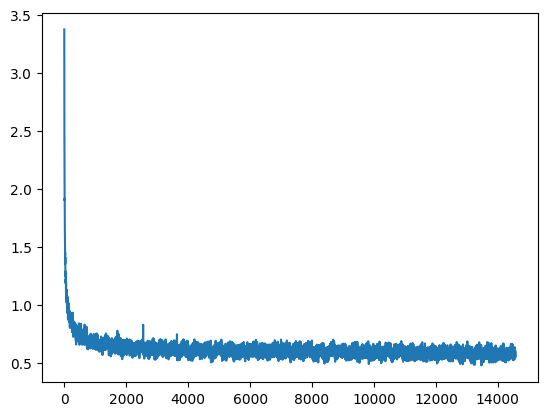

In [7]:
optimizer = torch.optim.AdamW(gru.parameters(), lr=0.01)

dgru.training_loop(
    model=gru, 
    train_data=train, 
    test_data=test, 
    loss_fn=nn.CrossEntropyLoss(ignore_index=0),
    optimizer=optimizer,
    n_epochs=40, 
    batch_size=256,
    eval_sample_frac=0.5,
    track_losses=True
)

In [8]:
dl = DataLoader(test, batch_size=32, shuffle=True)
yb, xb = next(iter(dl))

for i in range(10):
    print(
        wd.dec(yb[i]), ' : ',
        wd.dec(gru.predict(xb[i].unsqueeze(1).T)[0])
    )

farry  :  frairie
cebulski  :  cibeljky
pullum  :  polomb
compellingly  :  compellingly
sherwin  :  scharewen
fyfe  :  phyf
bosses  :  boscis
validate  :  valdayate
dorea  :  dorria
emeritus  :  imiterace


## Transformer Decoder